In [22]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from tqdm.notebook import tqdm
rng = np.random.default_rng()

In [23]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/emnist/emnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [24]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [25]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [26]:
from scipy.signal import convolve

num_classes = 47

# k-cap on convolved input pixels
cap_size = 100
n_examples = 1000
examples = np.zeros((num_classes, n_examples, 784))
for i in range(num_classes):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

In [27]:
n_in = 784
n_neurons = cap_size * num_classes
n_out = n_neurons
sparsity = 0.1
n_rounds = 100
num_hidden = 0
beta = 1.0

# Random mask on input-learning area connections
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

# Random mask on output-learning area connections
mask_b = rng.random((n_neurons, n_neurons)) < sparsity
B = np.ones((n_neurons, n_neurons)) * mask_b
B /= B.sum(axis=0)

# Random mask on intra-area recurrent connections
# Choose 10% of connections and not the diagnal
mask_w = (rng.random((num_hidden*2+1, n_neurons, n_neurons)) < sparsity) \
    & np.repeat(np.logical_not(np.eye(n_neurons, dtype=bool))[np.newaxis, ...], num_hidden*2+1, axis=0)
W = np.ones((num_hidden*2+1, n_neurons, n_neurons)) * mask_w
W /= W.sum(axis=1, keepdims=True)


if num_hidden != 0:

    # Random mask on inter-area forward connections
    # Choose 10% of connections
    mask_fw = (rng.random((num_hidden, n_neurons, n_neurons)) < sparsity)
    C_fw = np.ones((num_hidden, n_neurons, n_neurons)) * mask_fw
    C_fw /= C_fw.sum(axis=1, keepdims=True)

    # Random mask on intra-area feedback connections
    # Choose 10% of connections
    mask_fb = (rng.random((num_hidden, n_neurons, n_neurons)) < sparsity)
    C_fb = np.ones((num_hidden, n_neurons, n_neurons)) * mask_fb
    C_fb /= C_fb.sum(axis=1, keepdims=True)

In [28]:
# Model with reccurent, forward, and feedback connections


bias = np.zeros((num_hidden*2+1, n_neurons))
b = -1

activations = np.zeros((num_classes, n_rounds, num_hidden*2+1+1, n_neurons))

# Iterate over each class
for i in range(num_classes):
    
    # Iterate over several examples
    for t in range(n_rounds):
        
        input = examples[i, t]
        
        # Apply supervision: set assembly in the output area corresponding to class i to 1
        activations[i, t, -1, i*cap_size:i*cap_size+cap_size] = 1 
        output = activations[i, t, -1]
        
        if t == 0: 
            continue
            
        if num_hidden != 0:
        
            # calculate forward activations
            activations[i, t, 0] = k_cap(input@A + activations[i, t-1, 0]@W[0] + bias[0], cap_size)
            for l in range(1, num_hidden):
                activations[i, t, l] = k_cap(
                    activations[i, t-1, l-1]@C_fw[l-1] + \
                    activations[i, t-1, l]@W[l] + \
                    bias[l], cap_size
                )
                
            # calculate middle learning area activations
            activations[i, t, num_hidden] = k_cap(
                activations[i, t-1, num_hidden-1]@C_fw[num_hidden-1] + \
                activations[i, t-1, num_hidden]@W[num_hidden] + \
                activations[i, t-1, num_hidden+1]@C_fb[0] + \
                bias[num_hidden], cap_size
            ) 

            
            # calculate backward activations
            for l in range(num_hidden+1, num_hidden*2):
                activations[i, t, l] = k_cap(
                    activations[i, t-1, l]@W[l] + \
                    activations[i, t-1, l+1]@C_fb[l-num_hidden] + \
                    bias[l], cap_size
                )
            activations[i, t, -2] = k_cap(output@B + activations[i, t-1, -2]@W[-1] + bias[-1], cap_size) 
                

            # update weights
            A[(input > 0)[:, np.newaxis] & (activations[i, t, 0] > 0)[np.newaxis, :]] *= 1 + beta
            
            for l in range(num_hidden):
                W[l][(activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]] *= 1 + beta
                C_fw[l][((activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l+1] > 0)[np.newaxis, :]) & (mask_fw[l] > 0)] *= 1 + beta
   
            
            for l in range(num_hidden, num_hidden*2):
                W[l][(activations[i, t-1, l] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]] *= 1 + beta
                C_fb[l-num_hidden][((activations[i, t-1, l+1] > 0)[:, np.newaxis] & (activations[i, t, l] > 0)[np.newaxis, :]) & (mask_fb[l-num_hidden] > 0)] *= 1 + beta
        
            W[-1][(activations[i, t-1, -1] > 0)[:, np.newaxis] & (activations[i, t, -1] > 0)[np.newaxis, :]] *= 1 + beta
            
            B[(output > 0)[:, np.newaxis] & (activations[i, t, -2] > 0)[np.newaxis, :]] *= 1 + beta
        
            
        
        else:
            activations[i, t, 0] = k_cap(
                input@A + activations[i, t-1, 0]@W[0] + output@B + bias[0], cap_size
            ) 
            
            A[(input > 0)[:, np.newaxis] & (activations[i, t, 0] > 0)[np.newaxis, :]] *= 1 + beta
            W[0][(activations[i, t-1, 0] > 0)[:, np.newaxis] & (activations[i, t, 0] > 0)[np.newaxis, :]] *= 1 + beta
            B[(output > 0)[:, np.newaxis] & (activations[i, t, 0] > 0)[np.newaxis, :]] *= 1 + beta
        
    A /= A.sum(axis=0, keepdims=True)
    B /= B.sum(axis=0, keepdims=True)
    W /= W.sum(axis=1, keepdims=True)
    if num_hidden != 0:
        C_fw /= C_fw.sum(axis=1, keepdims=True)
        C_fb /= C_fb.sum(axis=1, keepdims=True)

    bias[activations[i, t, :-1] > 0] += b
    
# inverse feedback weights and normalize
B = B.T / B.T.sum(axis=0, keepdims=True)
if num_hidden != 0:
    C_fb = np.transpose(C_fb, (0, 2, 1)) / np.transpose(C_fb, (0, 2, 1)).sum(axis=1, keepdims=True)
    C = np.concatenate([C_fw, C_fb], axis=0)

In [29]:
if num_hidden != 0:
    l = 0
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    ax[0].imshow(C[l, :100, :100])
    ax[1].imshow(C[l, :100, :100])  

In [30]:
num_learn_area = num_hidden * 2 + 1
n_rounds = num_learn_area + 2
act_test = np.zeros((num_classes, n_rounds+1, num_learn_area+1, n_examples, n_neurons))

for i in tqdm(np.arange(num_classes)):
    
    input = examples[i]
    
    # Run each example through the model n_round times
    for t in range(n_rounds):
        
        act_test[i, t+1, 0] = k_cap(input@A + act_test[i, t, 0]@W[0] + bias[0], cap_size)
        
        for l in range(1, num_learn_area):
            act_test[i, t+1, l] = k_cap(act_test[i, t, l-1]@C[l-1] + act_test[i, t, l]@W[l] + bias[l], cap_size)
        
        act_test[i, t+1, -1] = k_cap(act_test[i, t, -2]@B, cap_size)
        

  0%|          | 0/47 [00:00<?, ?it/s]

In [31]:
# output area
outputs = act_test[:, :, -1, ...]
outputs.shape

(47, 4, 1000, 4700)

In [32]:
# middle learning area
act_l = act_test[:, :, num_hidden, ...]
act_l.shape

(47, 4, 1000, 4700)

In [33]:
idx = np.arange(n_out)
idx

array([   0,    1,    2, ..., 4697, 4698, 4699])

In [34]:
idx_l = np.full(n_neurons, -1, dtype=int)
act = activations[:, -1, num_hidden, :].copy()  
for i in range(num_classes):
    idx_l[i*cap_size:(i+1)*cap_size] = act[i].argsort()[-cap_size:][::-1]
    act[:, idx_l[i*cap_size:(i+1)*cap_size]] = -1

<IPython.core.display.Javascript object>


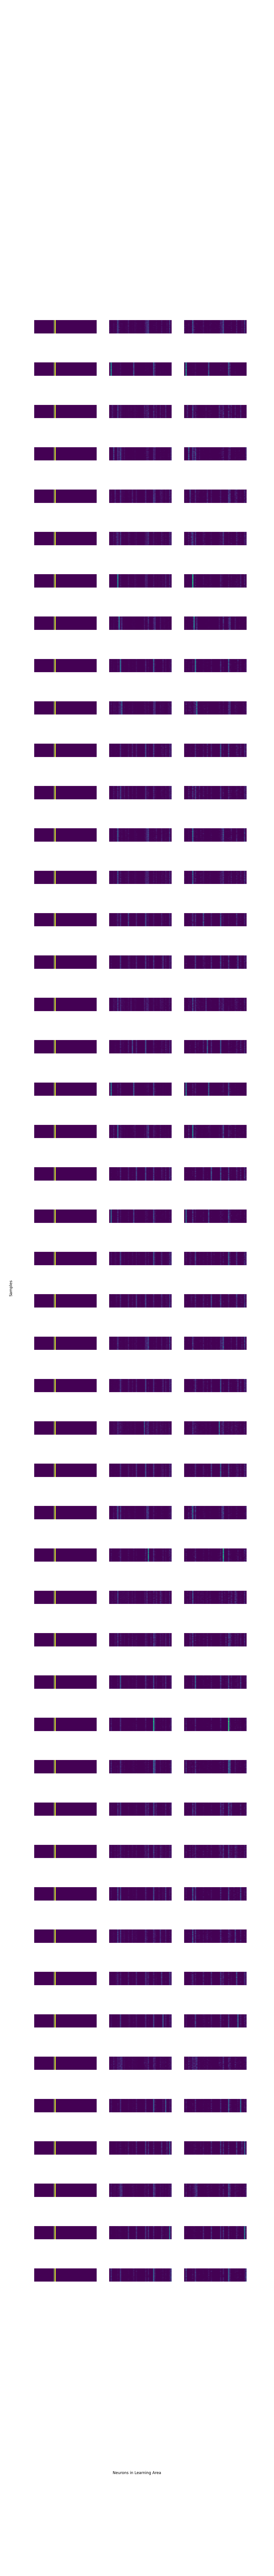

Text(0.04, 0.5, 'Samples')

In [35]:
fig, axes = plt.subplots(num_classes, n_rounds, figsize=(10, 2 * num_classes), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons in Learning Area', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>


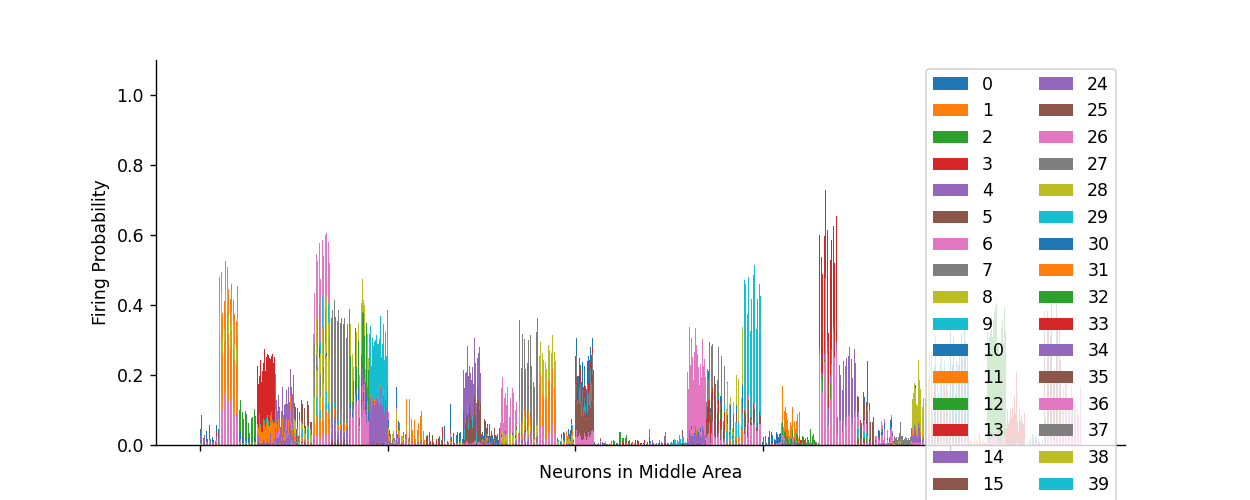

Text(0, 0.5, 'Firing Probability')

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(num_classes):
    # Pass each sample to the model and get its result
    ax.bar(np.arange(n_neurons), act_l[i, -1].mean(axis=0)[idx_l], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons in Middle Area')
ax.set_ylabel('Firing Probability')

<IPython.core.display.Javascript object>


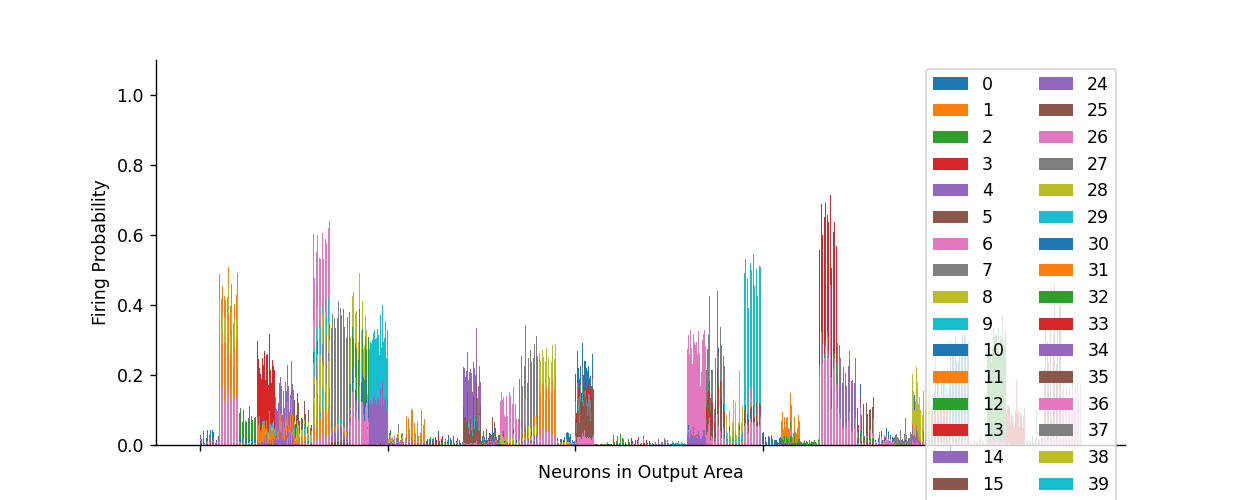

Text(0, 0.5, 'Firing Probability')

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(num_classes):
    # Pass each sample to the model and get its result 
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons in Output Area')
ax.set_ylabel('Firing Probability')

In [38]:
# We know the assembly of the output area by construction
c = np.zeros((num_classes, n_neurons))
for i in range(num_classes):
    c[i, i*cap_size: i*cap_size+cap_size] = 1

In [39]:
# outputs (10, n_rounds+1, n_examples, n_neurons)
predictions = (outputs[:, -1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(num_classes)[:, np.newaxis]).sum(axis=-1) / n_examples

In [40]:
acc, acc.mean()

(array([0.025, 0.433, 0.084, 0.256, 0.16 , 0.113, 0.632, 0.381, 0.398,
        0.341, 0.007, 0.053, 0.01 , 0.009, 0.223, 0.03 , 0.109, 0.276,
        0.264, 0.002, 0.223, 0.   , 0.011, 0.009, 0.004, 0.   , 0.312,
        0.268, 0.124, 0.532, 0.026, 0.064, 0.01 , 0.658, 0.244, 0.096,
        0.01 , 0.018, 0.173, 0.202, 0.304, 0.006, 0.332, 0.086, 0.007,
        0.392, 0.146]),
 0.17155319148936174)

In [128]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

In [202]:
batch_size = 10
v = 0.1 * rng.standard_normal((num_classes, n_neurons))
targets = np.zeros((batch_size*num_classes, num_classes))
momentum = 0.9
lr = 1e-2
epochs = 10

for i in range(10):
    targets[i*10:(i+1)*10, i] = 1
update = np.zeros_like(v)

In [203]:
outputs.shape

(10, 4, 5000, 2000)

In [204]:
for _ in tqdm(range(epochs)):
    permutation = rng.permutation(n_examples - 1000)
    for j in range((n_examples - 1000) // batch_size):
        batch = outputs[:, -1, permutation[j*10:(j+1)*10]].reshape(num_classes*batch_size, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = momentum * update + lr * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0) / batch_size
        v -= update

  0%|          | 0/10 [00:00<?, ?it/s]

In [205]:
((outputs[:, -1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000

0.788725

In [206]:
((outputs[:, -1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000

0.7361

In [178]:
from sklearn.linear_model import LogisticRegression

train_X = outputs[:, -1, :-1000, :].reshape(-1, n_neurons)
train_y = np.arange(10).repeat(4000)
clf = LogisticRegression(random_state=0, max_iter=100).fit(train_X, train_y)
clf.score(train_X, train_y)

/Users/eliz/anaconda3/envs/fwt/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.78215

In [179]:
test_X = outputs[:, -1, -1000:, :].reshape(-1, n_neurons)
test_y = np.arange(10).repeat(1000)
clf.score(test_X, test_y)

0.7425